# Atmosphere Phase Screen Gradient

Phase screens are computed with an `Atmosphere` and a `Source` object.
Lets import the `ceo` module first.

In [1]:
import math
import numpy as np
import ceo
%pylab inline

Populating the interactive namespace from numpy and matplotlib


The atmosphere is defined with

In [16]:
#atm = ceo.Atmosphere(0.15,30,altitude=10e3,wind_speed=10)
atm =  ceo.GmtAtmosphere(0.15,30)

A V band on-axis source is defined first,

In [17]:
NL = 20
NA = NL+1
src = ceo.Source("V",resolution=(NA,NA))

The telescope pupil is defined as the Giant Magellan Telescope and mask for the deformable mirror actuators is also set.

In [18]:
D = 8.0
#tel = ceo.Telescope(NL*16)
tel = ceo.Telescope(NL*16,D)
dm  = ceo.Mask(NA,D)

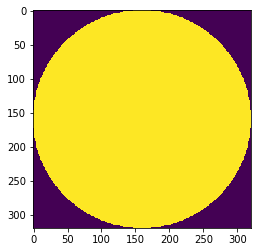

In [19]:
imshow(tel.f.host(shape=(NL*16,NL*16)),interpolation='None')

A `Centroiding` object is defined, it will contains the phase screen gradient.
The `fried_geometry` method computes the DM valid actuator mask according to the telescope pupil shape and the given intensity `threshlod`.
The `Source` object is masked with the dm mask.

In [20]:
d = D/NL
cog = ceo.Centroiding(NL)
cog.fried_geometry(dm, tel, 16, 0.5)
src.masked(dm)

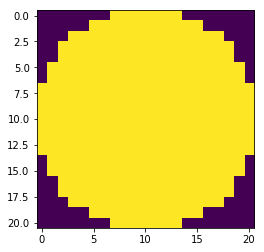

In [21]:
imshow(dm.f.host(shape=(NA,NA)),interpolation='None')

The $n \times n$ phase screen of $D$ width is computed next

In [22]:
p = D/(NA-1)
atm.get_phase_screen(src,p,NA,p,NA,0.0)

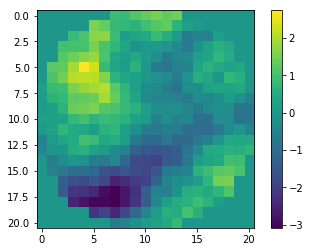

In [23]:
dm_mask = dm.f
src_phase = src.phase
imshow(src_phase.host(units='micron',zm=True,mask=dm_mask.host()),interpolation='None')
colorbar()

The phase screen gradient is computed with the `Atmosphere` method `get_phase_screen_gradient`.
The gradient is computed over a square lenslet array of size $N_L \times N_L$ with $d$ the pitch in meter.
The phase screen gradient is computed for a given `Source` object that contains one or more guide stars.
The phase screen gradient can be computed for a given time delay.
The $c_x$ and $c_y$ centroids are saved in a `Centroiding` object.

In [24]:
atm.get_phase_screen_gradient(cog,NL,d,src,0.0)
c = cog.c.host(units='arcsec')

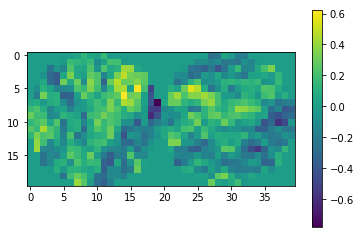

In [25]:
imshow(c.reshape(NL*2,NL).transpose(),interpolation='None')
colorbar()

From the phase gradient, the phase screen can be reconstructed with a linear minimim mean square error reconstructor (LMMSE).
A `Lmmse` object is used to perform the phase estimation.
The parameters are:
- an `Atmosphere` object,
- a `Source` object representing the guide star(s),
- the number of guide stars,
- a `Source` object representing the star(s) in the estimation direction(s),
- the number of star(s) in the estimation direction(s),
- the wavefront sampling step in meter,
- the number of sample across the wavefront,
- a `Mask` object representing the pupil,
- the iterative solver.

In [26]:
src_lmmse = ceo.Lmmse(atm,src,src,d,NL,dm,"MINRES")
src_lmmse.estimation(cog)

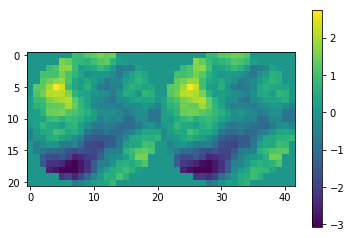

In [27]:
src_lmmse_phase = src_lmmse.phase
imshow(np.concatenate((src_phase.host_data,
                            src_lmmse_phase.host(units='micron',zm=True,mask=dm_mask.host())),axis=1),
           interpolation='none')
colorbar()

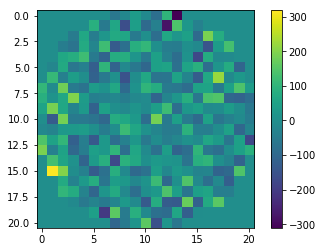

In [28]:
ps_e = src_lmmse_phase.host_data - src_phase.host_data
imshow(ps_e*1e3,interpolation='none')
colorbar()

In [29]:
print "wavefront error: %5.2fnm" % (np.std(ps_e[dm_mask.host_data!=0])*1e3)

wavefront error: 83.23nm


In [30]:
n = 6
nPx = n*NL+1

In [31]:
gs = ceo.Source("K",resolution=(nPx,nPx))
tel_osf = ceo.Telescope(nPx,D)
gs.masked(tel_osf)

In [32]:
gs_lmmse = ceo.Lmmse(atm,gs,gs,d,NL,tel_osf,"MINRES",osf=n)
gs_lmmse.estimation(cog)

In [33]:
p = D/(nPx-1)
atm.get_phase_screen(gs,p,nPx,p,nPx,0.0)

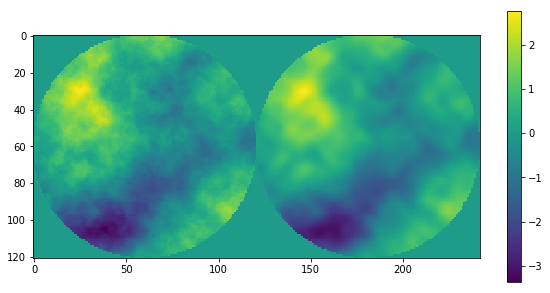

In [34]:
tel_osf_mask = tel_osf.f
gs_phase = gs.phase
gs_lmmse_phase = gs_lmmse.phase
fig = figure(figsize=(10,5))
imshow(np.concatenate((gs_phase.host(units='micron',zm=True,mask=tel_osf_mask.host()),
                            gs_lmmse_phase.host(units='micron',zm=True,mask=tel_osf_mask.host())),axis=1),
           interpolation='none')
colorbar()

wavefront error: 94.07nm


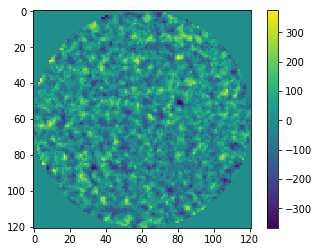

In [35]:
gs_ps_e = gs_lmmse_phase.host_data - gs_phase.host_data
imshow(gs_ps_e*1e3,interpolation='none')
colorbar()
print "wavefront error: %5.2fnm" % (np.std(gs_ps_e.ravel()[tel_osf_mask.host_data.ravel()!=0])*1e3)